# Calculating Star Formation Rate Density

In another notebook, we calculated the Schechter function using various parameters from various literature values. We also computed the luminosity density by integrating the Schechter function. We can use a conversion factor to convert this luminosity density into the star formation rate density, such a conversion factor is usually denoted by $\kappa$. There may be different values of $\kappa$ depending upon the wavelength band of the spectrum used (i.e., IR or UV). In the present notebook, we shall use the values of this conversion factor from Madau & Dickinson (2014). Their values are,

$$\kappa_{FUV} = 2.2 \times 10^{-10} M_\odot year^{-1} L_\odot^{-1}$$ and $$\kappa_{IR} = 4.5 \times 10^{-44} M_\odot year^{-1} erg^{-1} s$$

Here, we note that the value of $\kappa_{FUV}$ is at $1500$ angstrom and it is in the units of solar luminosity, so we want to divide this value to the solar luminosity to find $\kappa_{FUV}$ in cgs units.

We first aim to use values for the Schechter function from Bouwens et al. (2012) to compute the luminosity density at various redshifts. Later, we use $\kappa_{FUV}$ (since Bouwens et al. 2012 used UV range) to measure the Star formation rate density. Finally, we shall plot the results.

After testing the code for values from Bouwens et al. (2012), we repeat the procedure for various other works for different spectral range and different redshifts with different Schechter parameters.

Let's start with the Bouwens et al. (2012) parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import utils as utl

## Calculation of SFRD for Bouwens et al. (2012)

Below we read all of the required parameters from the paper, and list them.

In [2]:
# Redshift
z_bou = np.array([4,5,6,7,8])

# Characteristic absolute magnitude
mst_bou = np.array([-20.98, -20.60, -20.37, -20.14, -20.10])
msterr_bou = np.array([0.10, 0.23, 0.30, 0.26, 0.52])

# Characteristic luminosity
lst_bou = np.array([])
lsterr_bou = np.array([])

for i in range(len(mst_bou)):
    mst1 = np.random.normal(mst_bou[i], msterr_bou[i], 10000)
    lst1 = utl.m_to_l_wave(mst1, 1500)
    lst_bou = np.hstack((lst_bou, np.mean(lst1)))
    lsterr_bou = np.hstack((lsterr_bou, np.std(lst1)))


# Normalisation constant
phi_bou = np.array([1.3, 1.4, 1.4, 0.86, 0.59])*0.001
phierr_bou = np.array([0.2, 0.6, 0.85, 0.545, 0.69])*0.001

# Alpha
alp_bou = np.array([-1.73, -1.79, -1.73, -2.01, -1.91])
alperr_bou = np.array([0.005, 0.12, 0.20, 0.21, 0.32])

# Kappas
sol_lum = (con.L_sun*1e7).value
kap_uv = 2.2e-10/sol_lum
kap_ir = 4.5*10**(-44)

# Range of Luminosities (or absolute magnitudes) used
mags_bou = np.linspace(-24, -13, 1000)
lums_bou = utl.m_to_l_wave(mags_bou, 1500)

#print(np.log10(lst_bou))
#print(np.log10(lsterr_bou))
#print(np.log10(lums_bou))

Below we present our calculation for SFRD for various redshifts ranging from $4$ to $8$ with different parameters for the Schechter function as presented in Bouwens et al. (2012). Initially, we won't consider the error propogation; later, if this goes perfect, then we'd add the error propogation.

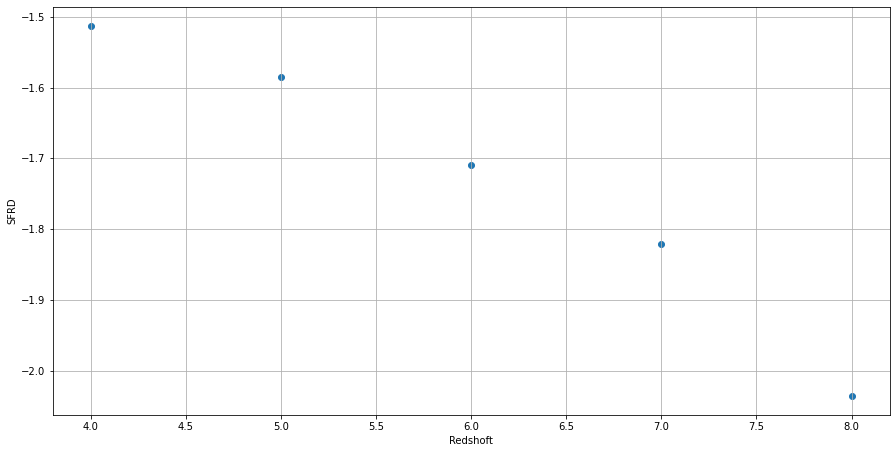

In [3]:
# Calculations without error propogation
sfrd_bou_wo = np.array([])

for i in range(len(z_bou)):
    sfr_wo = utl.sfrd(lum=lums_bou, lum1=lst_bou[i], phi1=phi_bou[i], alpha=alp_bou[i], kappa=kap_uv)
    sfrd_bou_wo = np.hstack((sfrd_bou_wo, sfr_wo))

log_sfr_bou_wo = np.log10(sfrd_bou_wo)#*utl.lam_to_nu(1500))

plt.figure(figsize=(15,7.5))
plt.scatter(z_bou, log_sfr_bou_wo)
plt.xlabel('Redshoft')
plt.ylabel('SFRD')
plt.grid()

It seems that the magnitude of SFRD matches with their corresponding values from Madau \& Dickinson (2014) paper. We now describe the way we propogate the errors in our calculation.

### Error propogation

It is important to propogate uncertainties in the $M^*$, $\phi^*$ and $\alpha$ properly in final computed star formation rate density. We used Monte-Carlo methods to achieve this goal. We generate a random normal distribution of each parameters around its mean value and standard deviation equal to the uncertainty in the parameter (to reduce the computing time, we are currently using each array of size 50). Later we used this random normal distributions in $M^*$, $\phi^*$ and $\alpha^*$ to calculate the Schechter function (for each combination of values for these parameters from the distribution). Then we integrate the Schechter function accordingly (again, for each combination of values of parameters). Doing so, we would have an array of integration values (each value corresponds to the different Schechter function). We then measure the mean and standard deviation of this array to find the uncertainty in the luminosity density --- once, we got the errors in luminosity density, it is fairly easy to propogate this errors in the calculation of the star formation rate density since the conversion factor ($\kappa$) does not have any uncertainty.

We implement this whole procedure to calculate the Star Formation Rate Density in `sfr` function from `util.py` file. Interested use can visit the same file for the code. In the present notebook, we directly use the `utils.sfr` function to compute SFRD.

  0%|          | 0/50 [00:00<?, ?it/s]
 SFRD
0.04451893133818119
0.008154728266161934
  0%|          | 0/50 [00:00<?, ?it/s]
 SFRD
0.04933605503521446
0.029465710031112365
  0%|          | 0/50 [00:00<?, ?it/s]
 SFRD
0.03250582055557476
0.02910792664562514
  0%|          | 0/50 [00:00<?, ?it/s]
 SFRD
0.0484393263865706
0.07437454704726917
 66%|██████▌   | 33/50 [01:32<00:48,  2.85s/it]/home/jayshil/Documents/UNIGE/APL/APL2/csfrd/utils.py:113: RuntimeWarning: invalid value encountered in power
  cd = (lum/lum1)**alpha
100%|██████████| 50/50 [02:22<00:00,  2.85s/it]

 SFRD
nan
nan

 Log sfrd
-1.3582956803336073
0.08311067685948947

 Log sfrd
-1.4048540678187738
0.3873677195004773

 Log sfrd
-1.5931785381341497
0.450696953424887

 Log sfrd
-1.3184419540072132
0.46959976315333596

 Log sfrd
nan
nan


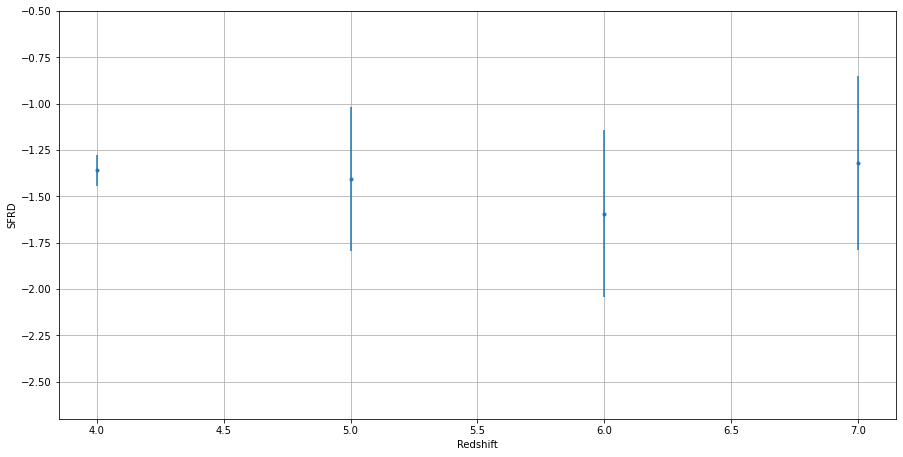

In [5]:
sfrd_bou = np.array([])
sfrd_err_bou = np.array([])

for i in range(len(z_bou)):
    sfr1, sfr_e1 = utl.sfrd1(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1err=phierr_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)
    print('\n SFRD')
    print(sfr1)
    print(sfr_e1)
    sfrd_bou = np.hstack((sfrd_bou, sfr1))
    sfrd_err_bou = np.hstack((sfrd_err_bou, sfr_e1))

log_sfrd_bou = np.array([])
log_sfrd_bou_err = np.array([])

for i in range(len(z_bou)):
    sfrd12 = np.abs(np.random.normal(sfrd_bou[i], sfrd_err_bou[i], 10000))
    log_sfrd12 = np.log10(sfrd12)
    lgm = np.mean(log_sfrd12)
    log_sfrd_bou = np.hstack((log_sfrd_bou, lgm))
    lgst = np.std(log_sfrd12)
    print('\n Log sfrd')
    print(lgm)
    print(lgst)
    log_sfrd_bou_err = np.hstack((log_sfrd_bou_err, lgst))

plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou, yerr=log_sfrd_bou_err, fmt='.')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.ylim([-2.7, -0.5])
plt.grid()